<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Week2_partB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset B (regression): for the second set of 5 small programming tasks, use the Haxby dataset provided by the nilearn package, which can be downloaded using the code below. This is a dataset of functional brain scans (functional MRI measurements from one subject) acquired while individuals watched people’s faces or house pictures.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


The only relevant horizontal brain slice has 739 voxels.


/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_slicers.py:1333: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


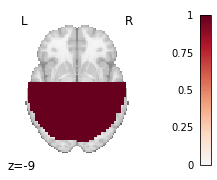

In [16]:
from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

from nilearn import datasets
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from matplotlib import pylab as plt

haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)

from nilearn.input_data import NiftiMasker
nifti_masker = NiftiMasker(smoothing_fwhm=8,
mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face',
dtype=int)

print('The only relevant horizontal brain slice has %i voxels.' %
process_mask[..., picked_slice].sum())

#plot that slice to get an impression of where the input variables are in the brain 
plot_stat_map(process_mask_img, cut_coords=[-9],
display_mode="z", cmap=plt.cm.RdBu_r)

Note: since there are many more input variables in this dataset, for ll of the following questions only generate plots of the first 17 input variables (your models should still be trained using all input ariables). For Q8 and Q9 use an 80/20% train/test split.

6. analogous to task 1 but using sklearn.linear_model.Ridge(default hyperparameters) instead of logistic regression, since the target is now continuous.

  Use sklearn.linear_model.Ridge(default hyperparameters) trained on all input_variables to perform uncertainty estimation. Draw 200 bootstrap samples from the dataset, and for each of these bootstrap datasets, fit your model on all 216 subjects (you will train 200 models). Plot the distribution of model parameters(.coef_)using pyplot.boxplot(). The distribution of the model parameters should be on the y-axis and the first 17 input variables on the x axis; the mean of each box is the original point estimate of the model coefficient (i.e., the original dataset, not the bootstrap data). 

In [65]:
input_variables = fmri_masked
input_variables.shape

(216, 739)

In [73]:
import scipy
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [71]:
# Let's create one bootstrap sample containing 216 observations to make sure we have everything we need
boot = resample(input_variables, replace=True, n_samples=216)
print (boot.shape)

(216, 739)


Looks like the size of our "boot" sample is correct, because it is the same as the original data. But we will need 200 of these samples, so let's make use of a for loop to create them iteratively:

In [77]:
# Setting the number of iterations
n_iterations = 200
# Pre-allocating the array where the coefficients of the 200 models will be appended
coefficients = []

for i in range(n_iterations):
    X_train = resample(input_variables, replace=True, n_samples=216) # X_train is the given bootstrap sample in the current iteration
    X_train = scaler.fit_transform(X_train) # Here we run the scaler on every iteration
    y_train = output_variable # y_train will remain the same as the original sample across iterations
    LinReg_boot = LinearRegression().fit(X_train,y_train) # We fit the LR model to the current bootstrap sample
    coefficients.append(LinReg_boot.coef_) # Store the coefficients in the "coefficients" array
    score = LinReg_boot.score(X_train, y_train) # We will also export the score for each bootstrap model (...)
    print('Accuracy: %.3f (%.3f)' % ((score), std(score))) # (...) and we will print it to make sure every model is different

Accuracy: 0.705 (0.000)
Accuracy: 0.651 (0.000)
Accuracy: 0.645 (0.000)
Accuracy: 0.637 (0.000)
Accuracy: 0.634 (0.000)
Accuracy: 0.614 (0.000)
Accuracy: 0.609 (0.000)
Accuracy: 0.698 (0.000)
Accuracy: 0.600 (0.000)
Accuracy: 0.596 (0.000)
Accuracy: 0.645 (0.000)
Accuracy: 0.606 (0.000)
Accuracy: 0.740 (0.000)
Accuracy: 0.752 (0.000)
Accuracy: 0.596 (0.000)
Accuracy: 0.535 (0.000)
Accuracy: 0.652 (0.000)
Accuracy: 0.639 (0.000)
Accuracy: 0.576 (0.000)
Accuracy: 0.633 (0.000)
Accuracy: 0.601 (0.000)
Accuracy: 0.614 (0.000)
Accuracy: 0.702 (0.000)
Accuracy: 0.603 (0.000)
Accuracy: 0.636 (0.000)
Accuracy: 0.627 (0.000)
Accuracy: 0.674 (0.000)
Accuracy: 0.734 (0.000)
Accuracy: 0.596 (0.000)
Accuracy: 0.620 (0.000)
Accuracy: 0.626 (0.000)
Accuracy: 0.571 (0.000)
Accuracy: 0.612 (0.000)
Accuracy: 0.667 (0.000)
Accuracy: 0.594 (0.000)
Accuracy: 0.568 (0.000)
Accuracy: 0.706 (0.000)
Accuracy: 0.668 (0.000)
Accuracy: 0.580 (0.000)
Accuracy: 0.654 (0.000)
Accuracy: 0.560 (0.000)
Accuracy: 0.610 

Overall model accuracies are indeed different from each other, which is good, and they seem to hover around the 0.6 value. Let's compute the model accuracy for the model with the original data to see if it's better than what we get with bootstrap samples:

In [78]:
input_variables = scaler.fit_transform(input_variables) # We replicate the pipeline by first standardizing the data 
LinReg = LinearRegression().fit(input_variables,output_variable)
score = LinReg.score(input_variables, output_variable)
print('Accuracy: %.3f (%.3f)' % ((score), std(score)))
usermeans = LinReg.coef_ # We will store the model paramaters in a variable called "usermeans" to be used later

Accuracy: 1.000 (0.000)


In [79]:
usermeans

array([-4.11818326e-02, -5.74960858e-02, -9.66362469e-03,  5.41394278e-02,
        1.90300327e-02, -3.45373750e-02,  4.62020114e-02, -1.67341344e-03,
        2.05154344e-03,  5.34438342e-03, -4.46547717e-02, -2.68764533e-02,
        4.20630947e-02,  9.97167081e-03, -3.83019000e-02,  2.26146914e-02,
        6.34077191e-03,  5.31657971e-02, -3.68162617e-03, -1.09592946e-02,
       -3.38747874e-02,  3.05605028e-02,  1.38339996e-02, -3.58582325e-02,
       -5.73652051e-03, -1.24922674e-03,  3.89917335e-03, -3.46667171e-02,
        2.43538618e-03,  1.47945229e-02, -1.85577068e-02, -2.70750262e-02,
       -5.34760877e-02, -4.78618704e-02,  4.85054497e-03,  7.69471237e-03,
        8.15391727e-03,  5.58814332e-02,  3.77442054e-02, -4.59015146e-02,
       -2.51988787e-02,  1.59476046e-02, -3.60473283e-02,  4.42414079e-03,
        1.39283426e-02, -2.23322064e-02, -3.42618302e-02, -3.30904722e-02,
       -4.76845913e-02, -2.88536344e-02, -5.64932786e-02, -6.66621998e-02,
        4.58983816e-02,  